In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json

import os

The 18 identifiers that make health information PHI are:

 - Names
 - Dates, except year
 - Telephone numbers
 - Geographic data
 - FAX numbers
 - Social Security numbers
 - Email addresses
 - Medical record numbers
 - Account numbers
 - Health plan beneficiary numbers
 - Certificate/license numbers
 - Vehicle identifiers and serial numbers including license plates
 - Web URLs
 - Device identifiers and serial numbers
 - Internet protocol addresses
 - Full face photos and comparable images
 - Biometric identifiers (i.e. retinal scan, fingerprints)
 - Any unique identifying number or code

In [22]:
deid_dict = {
    "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"],
    "name": ["fore_name", "surname"],
    "contact_details": ["address", "telephone_number", "email", "identification"],
    "address": ["address_line", "postcode"],
    "identification": ["passport_number", "driving_licence_number"],
    "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number"],
    "date": ["date_of_birth"],
    }


In [23]:
print(deid_dict.keys())


dict_keys(['de-identification_root_concept', 'name', 'contact_details', 'address', 'identification', 'healthcare_identifier', 'date'])


#### Meta_annotations will hold the contextual information of the concept.
"Subject": ["patient", "family", "clinician"] (unselected meta_ann will mean "other/ N/A")


/home/jonnysheldon/Documents/MedCAT/Creating_a_de-identification_terminology
                              from                           to
0   de-identification_root_concept                         name
1   de-identification_root_concept              contact_details
2   de-identification_root_concept        healthcare_identifier
3   de-identification_root_concept                         date
4                             name                    fore_name
5                             name                      surname
6                  contact_details                      address
7                  contact_details             telephone_number
8                  contact_details                        email
9                  contact_details               identification
10                         address                 address_line
11                         address                     postcode
12                  identification              passport_number
13                  identif

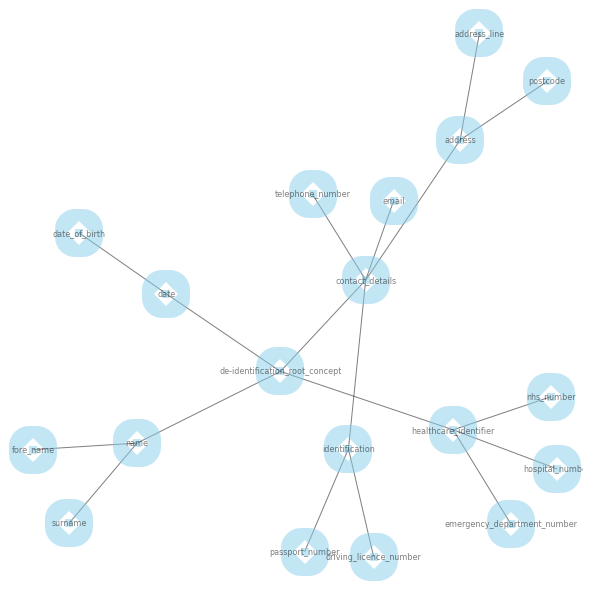

In [24]:
# TODO: visualise the terminology hierarchy
# https://python-graph-gallery.com/321-custom-networkx-graph-appearance/
print(os.getcwd())
df = pd.read_csv("cbd_diagram.csv")
print(df)
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')#, edge_attr=True)
 
# Graph with Custom nodes:
plt.figure(figsize=(8,8)) 
nx.draw(G, with_labels=True, node_size=60,font_size=8, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
pos=nx.spring_layout(G)
plt.show()

In [27]:
# TODO: Create a JSON file with the terminology structure with only the Fully specified names (FSN)
deid_json = json.dumps(deid_dict, sort_keys=True)
print(deid_json)


# TODO: create a CUI convention which reflects terminology structure
# code consists of 3 parts A = the name of the anonymisation dict. second letter = the term it belongs to (either the root, or the 1st child term) then a 4 letter code linking the term into the rest of the dictionary [first_parent][second parent][third parent][fourth parent]
# get rid of A- > ANON and Dash after the second letter
deid_cui_dict = {
    "de-identification_root_concept": "ANON-R0000",
    "name": "A-N-1000",
    "contact_details": "A-C-2000",
    "healthcare_identifier": "A-H-3000",
    "date": "A-D-4000",
    "fore_name": "A-N-1100",
    "surname": "A-N-1200",
    "address": "A-C-2100",
    "address_line": "A-C-2110",
    "postcode": "A-C-2120",
    "telephone_number":"A-C-2200",
    "email": "A-C-2300",
    "identification": "A-C-2400",
    "passport_number": "A-C-2410",
    "driving_licence_number": "A-C-2420",
    "nhs_number": "A-H-3100",
    "hospital_number": "A-H-3200",
    "emergency_department_number": "A-H-3300",
    "date_of_birth": "A-D-4100"
    }

{"address": ["address_line", "postcode"], "contact_details": ["address", "telephone_number", "email", "identification"], "date": ["date_of_birth"], "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"], "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number"], "identification": ["passport_number", "driving_licence_number"], "name": ["fore_name", "surname"]}


# Create a CDB CSV format file following the structure:

|cui|str|onto|tty|tui|sty|desc|
|--|--|--|--|--|--|--|

__cui__ - The concept unique identifier, this is simply an ID in your database

__str__ - String/Name of that concept. It is important to write all possible names and abbreviations for a concept of interest.

__onto__ - Source ontology, e.g. HPO, SNOMED, HPC,...

__tty__ - Term type e.g. PN - Primary Name. Primary names are important and I would always recommend to add this fields when creating your CDB. Important to distinguish from synoymns. 

__tui__ - Semantic type identifier - A unique identifier code for each semantic type.

__sty__ - Semantic type - AKA fully specified name of top level concept group

__desc__ - Description of this concept


In [28]:
# TODO: enrich the terminology with synonyms
# TODO: Create a csv file with each concept and concept unique identifier

# dictionary of root concepts for the de-id cui database
deid_sty = {
    "de-identification_root_concept": "A-R-0000",
    "name": "A-R-0000",
    "contact_details": "A-R-0000",
    "healthcare_identifier": "A-R-0000",
    "date": "A-R-0000",
    "fore_name": "A-N-1000",
    "surname": "A-N-1000",
    "address": "A-C-2000",
    "address_line": "A-C-2100",
    "postcode": "A-C-2100",
    "telephone_number":"A-C-2000",
    "email": "A-C-2000",
    "identification": "A-C-2000",
    "passport_number": "A-C-2400",
    "driving_licence_number": "A-C-2400",
    "nhs_number": "A-H-3000",
    "hospital_number": "A-H-3000",
    "emergency_department_number": "A-H-3000",
    "date_of_birth": "A-D-4000"
    }
# dictionary of descriptions for the de-id cui database
deid_desc = {
    "de-identification_root_concept": "root concept of de-identification",
    "name": "surname and forname",
    "contact_details": "non hospital identification and contact details",
    "healthcare_identifier": "hospital derived ID",
    "date": "personal dates",
    "fore_name": "given name including middle names",
    "surname": "all surnames",
    "address": "address and postcode",
    "address_line": "all address line items including city and country",
    "postcode": "all postcodes",
    "telephone_number":"telepone numbers both mobile and landline",
    "email": "email addresses",
    "identification": "non hospital identification",
    "passport_number": "possport number",
    "driving_licence_number": "driving licence",
    "nhs_number": "nhs numbers",
    "hospital_number": "hospital number from kings college hospital and other trusts",
    "emergency_department_number": "number given by kings college hospital emergency number",
    "date_of_birth": "date of birth"
    }

In [31]:
df = pd.DataFrame(deid_cui_dict.items(), columns=['str', 'cui'])
df["onto"] = "cat_anon"
df["tty"] ="PN"
df["tui"] = ""
sty_df = 
desc_df = pd.DataFrame(deid_desc.items(), columns=['str', 'desc'])
df = df.merge(sty_df, left_on="str",right_on="str")
df = df.merge(desc_df, left_on="str",right_on="str")
print(df)

TypeError: Can only merge Series or DataFrame objects, a <class 'str'> was passed

In [29]:
# read in list
def read_list(name, encode):
    with open(name, encoding = encode) as file:
        lines = [line.rstrip('\n') for line in file]
        return lines

In [30]:
# read in list of first names
def list_2_df(lst,cui, sty):
    """
    Takes a list of words, the cui (concept) and sty (root concept) nad turns this into a cat_anon dataframe
    """
    temp_df = pd.DataFrame({'str':lst})
    temp_df["cui"] = cui
    temp_df["onto"] = "cat_anon"
    temp_df["tty"] ="SN"
    temp_df["tui"] = ""
    temp_df["sty"] = ""
    temp_df["desc"] = ""
    return temp_df

In [11]:
first_names = read_list("cleaned_output/cleaned_first_name.txt","UTF-8")
last_names = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
hosp_num = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
nhs_num = read_list("cleaned_output/nhs_numbers.txt","UTF-8")
postcodes = read_list("cleaned_output/postcodes.txt","UTF-8")
mobile = read_list("cleaned_output/mobile_numbers.txt","UTF-8")
landline = read_list("cleaned_output/landline.txt","UTF-8")

In [13]:
first_df = list_2_df(first_names, "A-N-1100", "")
last_df = list_2_df(last_names, "A-N-1200", "")
hosp_df = list_2_df(hosp_num, "A-H-3200", "")
nhs_df = list_2_df(nhs_num, "A-H-3100", "")
postcode_df = list_2_df(postcodes, "A-C-2120", "")
mobile_df = list_2_df(mobile, "A-C-2200", "")
landline_df = list_2_df(landline, "A-C-2200", "")
print(postcode_df.head())

        str       cui      onto tty tui sty desc
0  TA23 0QX  A-C-2120  cat_anon  SN             
1   DT1 2QZ  A-C-2120  cat_anon  SN             
2  BH22 9HH  A-C-2120  cat_anon  SN             
3   SW2 1SP  A-C-2120  cat_anon  SN             
4   TW3 9SE  A-C-2120  cat_anon  SN             


In [18]:
#output broken up for to make files smaller
df_list1 = [df, first_df, last_df]
df_list2 = [hosp_df, postcode_df]
df_list3 = [nhs_df]
df_list4 = [landline_df, mobile_df]
output_df1 = pd.concat(df_list1)
output_df2 = pd.concat(df_list2)
output_df3 = pd.concat(df_list3)
output_df = pd.concat(df_list4)


In [16]:
output_df1.to_csv("cui1.csv", index=False)
output_df2.to_csv("cui2.csv", index=False)
output_df3.to_csv("cui3.csv", index=False)
output_df4.to_csv("cui4.csv", index=False)

NameError: name 'output_df4' is not defined

In [19]:
# full output
df_list = [df, first_df, last_df,hosp_df, postcode_df,nhs_df, landline_df, mobile_df]
full_output = pd.concat(df_list)
output_fill=full_output.to_csv("full_cui_medcat290121.csv", index=False)